## mount to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AICamp2023/MMagic

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AICamp2023/MMagic


## installaltion

In [2]:
!pip install clip transformers gradio 'httpx[socks]' diffusers==0.14.0
!pip install -U openmim
!mim install mmengine
!mim install 'mmcv>=2.0.0rc3'
!mim install 'mmdet>=3.0.0'
!rm -rf mmagic
!git clone https://github.com/open-mmlab/mmagic.git
%cd mmagic
!pip install -e .
%cd ..

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━

## GPU information

In [3]:
import os
import mmcv
import mmengine
import torch

if torch.cuda.is_available():
    print('CUDA is available')
    device_count = torch.cuda.device_count()
    print(f'Total number of CUDA devices: {device_count}')
    for i in range(device_count):
        device_name = torch.cuda.get_device_name(i)
        print(f'Device {i}: {device_name}')
else:
    print('CUDA is not available')

CUDA is available
Total number of CUDA devices: 1
Device 0: NVIDIA A100-SXM4-40GB


## black image colorization

In [9]:
os.makedirs('Results', exist_ok=True)
!python mmagic//demo//mmagic_inference_demo.py \
        --model-name inst_colorization \
        --img Test//IMG_9403.JPG \
        --result-out-dir Results//IMG_9403.JPG

2023-06-16 21:32:49.746972: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-16 21:32:49.801326: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 21:32:50.817522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmediting/inst_colorization/inst-colorizatioon_full_official_cocostuff-256x256-5b9d4eee.pth
06/16 21:32:56 - mmengine - WARNING - Failed to search registry with scope "mmagic"

## test to image

In [18]:
from mmagic.apis import MMagicInferencer

sd_inferencer = MMagicInferencer(model_name='stable_diffusion')
text_prompts = 'an unfurnished room'

sd_inferencer.infer(text=text_prompts, result_out_dir='Results//test2image.png')

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


06/16 22:08:54 - mmengine - INFO - Creating runwayml/stable-diffusion-v1-5 by 'HuggingFace'


  0%|          | 0/50 [00:00<?, ?it/s]

({'infer_results': <PIL.Image.Image image mode=RGB size=512x512 at 0x7F42C493A980>},
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7F42C493A980>)

## pics to pics with ControlNet

In [22]:
import cv2
import numpy as np
import mmcv
from mmengine import Config
from PIL import Image

from mmagic.registry import MODELS
from mmagic.utils import register_all_modules

register_all_modules()

cfg = Config.fromfile('mmagic//configs//controlnet//controlnet-canny.py')
controlnet = MODELS.build(cfg.model).cuda()

control_img = mmcv.imread('Results//test2image.png')
control = cv2.Canny(control_img, 100, 200)
control = control[:, :, None]
control = np.concatenate([control] * 3, axis=2)
control = Image.fromarray(control)

prompt = 'A fully furnished room with colorful wallpapers'

output_dict = controlnet.infer(prompt, control=control)
samples = output_dict['samples']
for idx, sample in enumerate(samples):
    sample.save(f'Results//sample_{idx}.png')
controls = output_dict['controls']
for idx, control in enumerate(controls):
    control.save(f'Results//control_{idx}.png')

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


06/16 22:21:42 - mmengine - INFO - Set model dtype to 'torch.float32'.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


06/16 22:21:50 - mmengine - INFO - Creating runwayml/stable-diffusion-v1-5 by 'HuggingFace'


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Do not support Xformers. Please install Xformers first. The program will run without Xformers.
06/16 22:21:53 - mmengine - INFO - Set model dtype to 'torch.float32'.
Do not support Xformers. Please install Xformers first. The program will run without Xformers.


100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


## mask a poster

In [34]:
def imread_rgb(image_dir):
    """cv2.imread + BRG2RGB """
    image = cv2.cvtColor(cv2.imread(image_dir), cv2.COLOR_BGR2RGB)
    return image

unfurnished = imread_rgb('Results//test2image.png')
edge = imread_rgb('Results//control_0.png')
furnished = imread_rgb('Results//sample_0.png')

# concatenate images horizontally (along the column axis)
image = cv2.hconcat([unfurnished, edge, furnished])

# create a black image with the same width as the concatenated image for writing text
text_image = np.zeros((100, image.shape[1], 3), np.uint8)

# define font, scale, color, thickness, and other properties.
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 2; font_color = (255, 255, 255); line_type = 2
text = 'here is your furnished room!'
(text_width, text_height) = cv2.getTextSize(text, font, font_scale, line_type)[0]
text_x = (text_image.shape[1] - text_width) // 2
text_y = (text_image.shape[0] + text_height) // 2


cv2.putText(text_image,
            text, (text_x, text_y),
            font,  font_scale, font_color, line_type)

poster = cv2.vconcat([image, text_image])
cv2.imwrite('Results//poster.jpg', cv2.cvtColor(poster, cv2.COLOR_RGB2BGR))

True

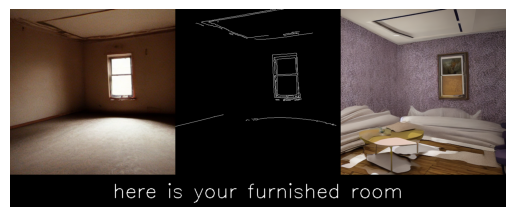

In [32]:
from matplotlib import pyplot as plt
plt.imshow(poster)
plt.axis('off')
plt.show()